<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Multi-Risk Derivatives Valuation

A specialty of DX Analytics is the valuation of derivatives instruments defined on multiple risk factors and portfolios composed of such derivatives. This section of the documentation illustrates the usage of the dedicated **multi-risk valuation classes**.

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
from dx import *
import seaborn as sns; sns.set()

In [3]:
import time
t0 = time.time()

There are the following **multiple risk factor valuation classes** available:

* `valuation_mcs_european_multi` for the valuation of multi-risk derivatives with European exercise
* `valuation_mcs_american_multi` for the valuation of multi-risk derivatives with American exercise

The handling of these classes is similar to building a portfolio of single-risk derivatives positions.

## Market Environments

**Market environments for the risk factors** are the starting point.

In [4]:
r = constant_short_rate('r', 0.06)

In [5]:
me1 = market_environment('me1', dt.datetime(2015, 1, 1))
me2 = market_environment('me2', dt.datetime(2015, 1, 1))

In [6]:
me1.add_constant('initial_value', 36.)
me1.add_constant('volatility', 0.1)  # low volatility
me1.add_constant('currency', 'EUR')
me1.add_constant('model', 'gbm')

In [7]:
me2.add_environment(me1)
me2.add_constant('initial_value', 36.)
me2.add_constant('volatility', 0.5)  # high volatility

We assum a **positive correlation** between the two risk factors.

In [8]:
risk_factors = {'gbm1' : me1, 'gbm2' : me2}
correlations = [['gbm1', 'gbm2', 0.5]]

## Valuation Environment

Similar to the instantiation of a `derivatives_portfolio` object, a **valuation environment** is needed (*unifying certain parameters/assumptions* for all relevant risk factors of a derivative).

In [9]:
val_env = market_environment('val_env', dt.datetime(2015, 1, 1))

In [10]:
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', dt.datetime(2015, 12, 31))
val_env.add_constant('frequency', 'W')
val_env.add_constant('paths', 5000)
val_env.add_curve('discount_curve', r)
val_env.add_constant('maturity', dt.datetime(2015, 12, 31))
val_env.add_constant('currency', 'EUR')

## valuation_mcs_european_multi

As an example for a multi-risk derivative with European exercise consider a **maximum call option**. With multiple risk factors, payoff functions are defined by adding key (the name strings) to the `maturity_value` array object. As with the portfolio valuation class, the multi-risk factor valuation classes get passed `market_environment` objects only and not the risk factor model objects themsemselves.

In [11]:
# European maximum call option
payoff_func = "np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']) - 38, 0)"
vc = valuation_mcs_european_multi(
            name='European maximum call',  # name
            val_env=val_env,  # valuation environment
            risk_factors=risk_factors,  # the relevant risk factors
            correlations=correlations,  # correlations between risk factors
            payoff_func=payoff_func)  # payoff function

In [12]:
vc.risk_factors

{'gbm1': <dx.dx_frame.market_environment at 0x1091ac650>,
 'gbm2': <dx.dx_frame.market_environment at 0x1091ac690>}

At instantiation, the respective **risk factor model objects** are instantiated as well.

In [13]:
vc.underlying_objects

{'gbm1': <dx.dx_models.geometric_brownian_motion at 0x1091ac890>,
 'gbm2': <dx.dx_models.geometric_brownian_motion at 0x1091ac990>}

Correlations are stored as well and the resulting **corrleation and Cholesky** matrices are generated.

In [14]:
vc.correlations

[['gbm1', 'gbm2', 0.5]]

In [15]:
vc.correlation_matrix

,gbm1,gbm2
gbm1,1.0,0.5
gbm2,0.5,1.0


In [16]:
vc.val_env.get_list('cholesky_matrix')

array([[ 1.       ,  0.       ],
       [ 0.5      ,  0.8660254]])

The **payoff of a European option** is a one-dimensional `ndarray` object.

In [17]:
np.shape(vc.generate_payoff())

(5000,)

**Present value estimations** are generated by a call of the `present_value` method.

In [18]:
vc.present_value()

7.649

The `update` method allows updating of certain parameters.

In [19]:
vc.update('gbm1', initial_value=50.)

In [20]:
vc.present_value()

16.738

In [21]:
vc.update('gbm2', volatility=0.6)

In [22]:
vc.present_value()

17.984

Let us reset the values to the original parameters.

In [23]:
vc.update('gbm1', initial_value=36., volatility=0.1)
vc.update('gbm2', initial_value=36., volatility=0.5)

When calculating **Greeks** the risk factor, depending on the specific statistic required, now has to be specified by providing its name.

In [24]:
vc.delta('gbm2', interval=0.5)

0.5694

In [25]:
vc.gamma('gbm2')

0.0204

In [26]:
vc.dollar_gamma('gbm2')

13.2192

In [27]:
vc.vega('gbm1')

6.3703

In [28]:
vc.theta()

-4.2273

In [29]:
vc.rho(interval=0.1)

25.6992

In [30]:
val_env.curves['discount_curve'].short_rate

0.06

### Sensitivities Positive Correlation

Almos in complete analogy to the single-risk valuation classes, **sensitivities** can be estimated for the multi-risk valuation classes. 

#### Sensitivities Risk Factor 1

Consider first the case from before with **positive correlation** between the two risk factors. The following estimates and plots the **sensitivities for the first risk factor `gbm1`**.

In [31]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm1', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm1', .5))
    ve.append(vc.vega('gbm1', 0.2))
vc.update('gbm1', initial_value=36.)

CPU times: user 421 ms, sys: 23.2 ms, total: 444 ms
Wall time: 463 ms


In [32]:
%matplotlib inline

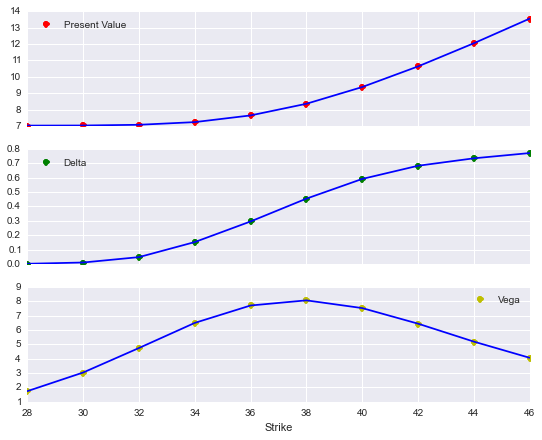

In [33]:
plot_option_stats(s_list, pv, de, ve)

#### Sensitivities Risk Factor 2

Now the **sensitivities for the second risk factor**.

In [34]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm2', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm2', .5))
    ve.append(vc.vega('gbm2', 0.2))

CPU times: user 328 ms, sys: 18.2 ms, total: 346 ms
Wall time: 348 ms


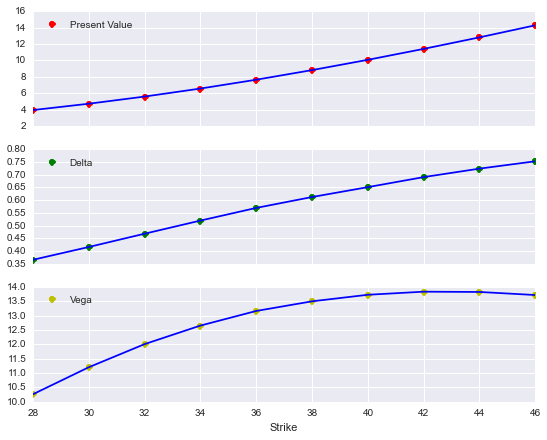

In [35]:
plot_option_stats(s_list, pv, de, ve)

### Sensitivities with Negative Correlation

The second case is for **highly negatively correlated** risk factors.

In [36]:
correlations = [['gbm1', 'gbm2', -0.9]]

In [37]:
# European maximum call option
payoff_func = "np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']) - 38, 0)"
vc = valuation_mcs_european_multi(
            name='European maximum call',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_func)

#### Sensitivities Risk Factor 1

Again, **sensitivities for the first risk factor** first.

In [38]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm1', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm1', .5))
    ve.append(vc.vega('gbm1', 0.2))
vc.update('gbm1', initial_value=36.)

CPU times: user 365 ms, sys: 17.5 ms, total: 382 ms
Wall time: 386 ms


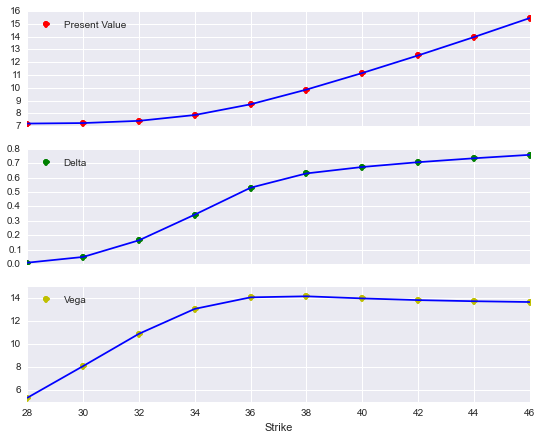

In [39]:
plot_option_stats(s_list, pv, de, ve)

#### Sensitivities Risk Factor 2

Finally, the **sensitivities for the second risk factor** for this second scenario.

In [40]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm2', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm2', .5))
    ve.append(vc.vega('gbm2', 0.2))

CPU times: user 338 ms, sys: 24.1 ms, total: 362 ms
Wall time: 362 ms


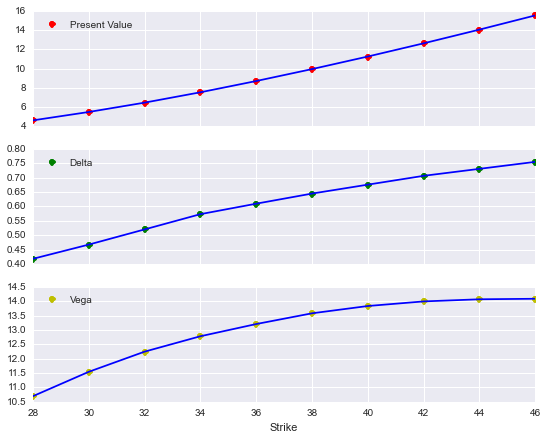

In [41]:
plot_option_stats(s_list, pv, de, ve)

### Surfaces for Positive Correlation Case

Let us return to the case of **positive correlation between the two relevant risk factors**.

In [42]:
correlations = [['gbm1', 'gbm2', 0.5]]

In [43]:
# European maximum call option
payoff_func = "np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']) - 38, 0)"
vc = valuation_mcs_european_multi(
            name='European maximum call',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_func)

#### Value Surface

We are now interested in the **value surface** of the derivative instrument for both different initial values of the first and second risk factor.

In [44]:
asset_1 = np.arange(28., 46.1, 4.)  # range of initial values
asset_2 = asset_1
a_1, a_2 = np.meshgrid(asset_1, asset_2)
  # two-dimensional grids out of the value vectors
value = np.zeros_like(a_1)

The following estimates for **all possible combinations** of the initial values---given the assumptions from above---the present value of the European maximum call option.

In [45]:
%%time
for i in range(np.shape(value)[0]):
    for j in range(np.shape(value)[1]):
        vc.update('gbm1', initial_value=a_1[i, j])
        vc.update('gbm2', initial_value=a_2[i, j])
        value[i, j] = vc.present_value()

CPU times: user 374 ms, sys: 20 ms, total: 394 ms
Wall time: 394 ms


The resulting plot then looks as follows. Here, a helper plot function of DX Analytics is used.

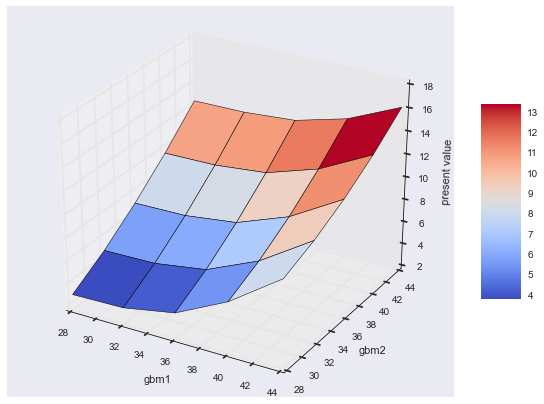

In [46]:
plot_greeks_3d([a_1, a_2, value], ['gbm1', 'gbm2', 'present value'])

#### Delta Surfaces

Applying a very similar approach, a **delta surface** for all possible combinations of the intial values is as easily generated.

In [47]:
delta_1 = np.zeros_like(a_1)
delta_2 = np.zeros_like(a_1)

In [48]:
%%time
for i in range(np.shape(delta_1)[0]):
    for j in range(np.shape(delta_1)[1]):
        vc.update('gbm1', initial_value=a_1[i, j])
        vc.update('gbm2', initial_value=a_2[i, j])
        delta_1[i, j] = vc.delta('gbm1')
        delta_2[i, j] = vc.delta('gbm2')

CPU times: user 1.33 s, sys: 84.8 ms, total: 1.41 s
Wall time: 1.44 s


The plot for the **delta surface of the first risk factor**.

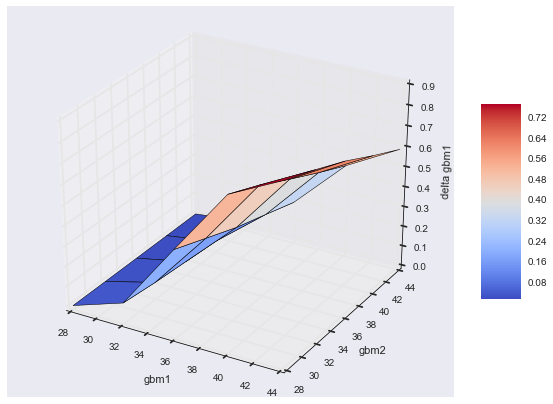

In [49]:
plot_greeks_3d([a_1, a_2, delta_1], ['gbm1', 'gbm2', 'delta gbm1'])

And the plot for the **delta of the second risk factor**.

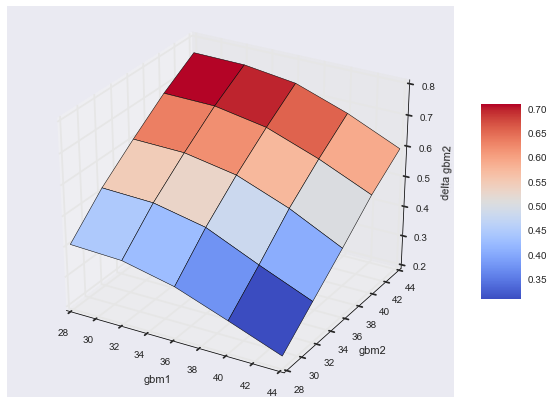

In [50]:
plot_greeks_3d([a_1, a_2, delta_2], ['gbm1', 'gbm2', 'delta gbm2'])

#### Vega Surfaces

The same approach can of course be applied to generate **vega surfaces**.

In [51]:
vega_1 = np.zeros_like(a_1)
vega_2 = np.zeros_like(a_1)

In [52]:
for i in range(np.shape(vega_1)[0]):
    for j in range(np.shape(vega_1)[1]):
        vc.update('gbm1', initial_value=a_1[i, j])
        vc.update('gbm2', initial_value=a_2[i, j])
        vega_1[i, j] = vc.vega('gbm1')
        vega_2[i, j] = vc.vega('gbm2')

The **surface for the first risk factor**.

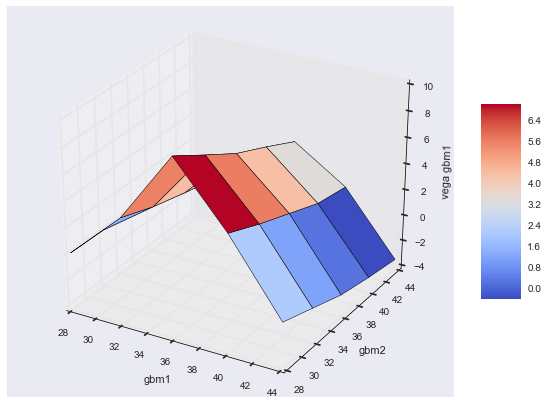

In [53]:
plot_greeks_3d([a_1, a_2, vega_1], ['gbm1', 'gbm2', 'vega gbm1'])

And the one for the second **risk factor**.

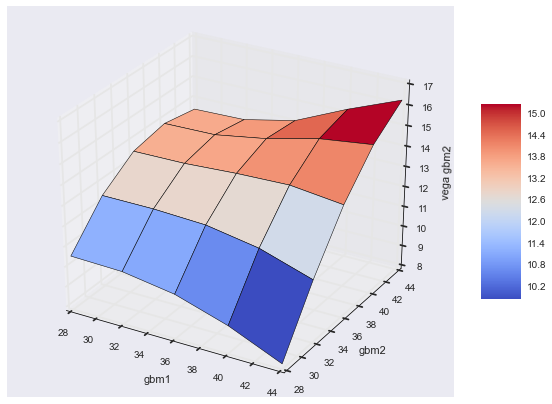

In [54]:
plot_greeks_3d([a_1, a_2, vega_2], ['gbm1', 'gbm2', 'vega gbm2'])

Finally, we reset the intial values and the volatilities for the two risk factors.

In [55]:
# restore initial values
vc.update('gbm1', initial_value=36., volatility=0.1)
vc.update('gbm2', initial_value=36., volatility=0.5)

## valuation_mcs_american_multi

In general, the modeling and handling of the valuation classes for American exercise is not too different from those for European exercise. The **major difference** is in the definition of payoff function.

### Present Values

This example models an **American minimum put** on the two risk factors from before.

In [56]:
# American put payoff
payoff_am = "np.maximum(34 - np.minimum(instrument_values['gbm1'], instrument_values['gbm2']), 0)"
# finer time grid and more paths
val_env.add_constant('frequency', 'B')
val_env.add_curve('time_grid', None)
  # delete existing time grid information
val_env.add_constant('paths', 5000)

In [57]:
# American put option on minimum of two assets
vca = valuation_mcs_american_multi(
            name='American minimum put',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_am)

In [58]:
vca.present_value()

4.568

In [59]:
for key, obj in vca.instrument_values.items():
    print np.shape(vca.instrument_values[key])

(261, 5000)
(261, 5000)


The **present value surface** is generated in the same way as before for the European option on the two risk factors. The computational burden is of course much higher for the American option, which are valued by the use of the **Least-Squares Monte Carlo approach (LSM)** according to Longstaff-Schwartz (2001).

In [60]:
asset_1 = np.arange(28., 44.1, 4.)
asset_2 = asset_1
a_1, a_2 = np.meshgrid(asset_1, asset_2)
value = np.zeros_like(a_1)

In [61]:
%%time
for i in range(np.shape(value)[0]):
    for j in range(np.shape(value)[1]):
        vca.update('gbm1', initial_value=a_1[i, j])
        vca.update('gbm2', initial_value=a_2[i, j])
        value[i, j] = vca.present_value()

CPU times: user 18.2 s, sys: 1.33 s, total: 19.5 s
Wall time: 19 s


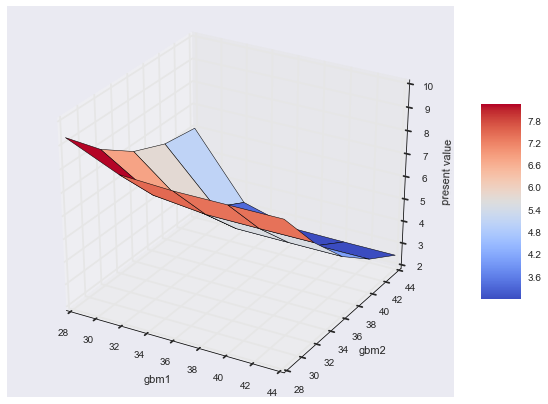

In [62]:
plot_greeks_3d([a_1, a_2, value], ['gbm1', 'gbm2', 'present value'])

### Delta Surfaces

The same exercise as before for the two **delta surfaces**.

In [63]:
delta_1 = np.zeros_like(a_1)
delta_2 = np.zeros_like(a_1)

In [64]:
%%time
for i in range(np.shape(delta_1)[0]):
    for j in range(np.shape(delta_1)[1]):
        vca.update('gbm1', initial_value=a_1[i, j])
        vca.update('gbm2', initial_value=a_2[i, j])
        delta_1[i, j] = vca.delta('gbm1')
        delta_2[i, j] = vca.delta('gbm2')

CPU times: user 1min 5s, sys: 4.54 s, total: 1min 10s
Wall time: 1min 7s


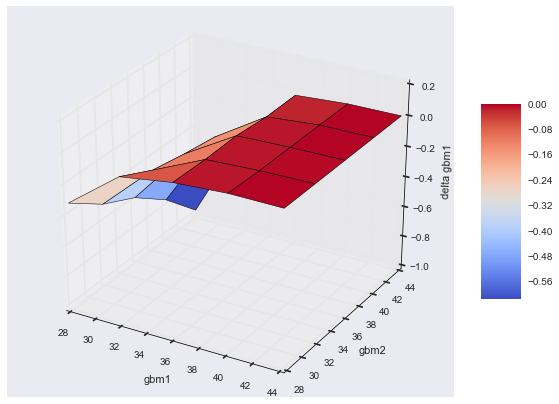

In [65]:
plot_greeks_3d([a_1, a_2, delta_1], ['gbm1', 'gbm2', 'delta gbm1'])

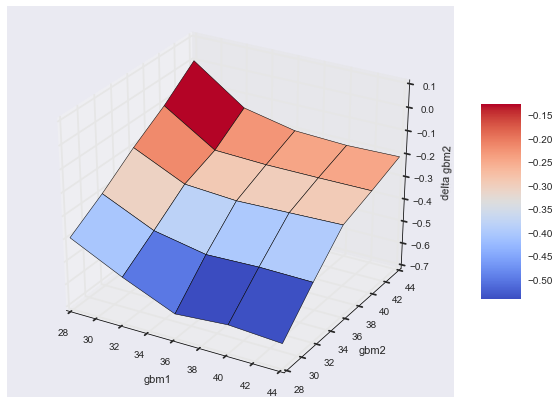

In [66]:
plot_greeks_3d([a_1, a_2, delta_2], ['gbm1', 'gbm2', 'delta gbm2'])

### Vega Surfaces

And finally for the **vega surfaces**.

In [67]:
vega_1 = np.zeros_like(a_1)
vega_2 = np.zeros_like(a_1)

In [68]:
%%time
for i in range(np.shape(vega_1)[0]):
    for j in range(np.shape(vega_1)[1]):
        vca.update('gbm1', initial_value=a_1[i, j])
        vca.update('gbm2', initial_value=a_2[i, j])
        vega_1[i, j] = vca.vega('gbm1')
        vega_2[i, j] = vca.vega('gbm2')

CPU times: user 1min 4s, sys: 4.31 s, total: 1min 8s
Wall time: 1min 5s


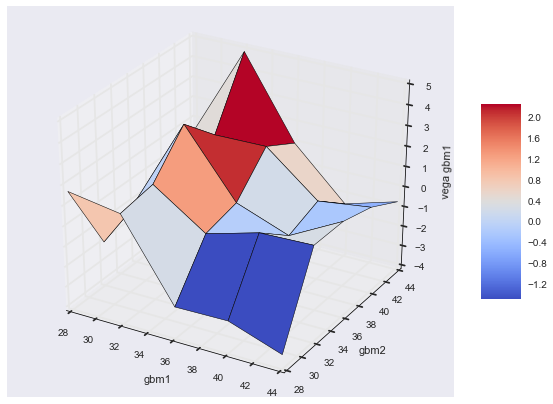

In [69]:
plot_greeks_3d([a_1, a_2, vega_1], ['gbm1', 'gbm2', 'vega gbm1'])

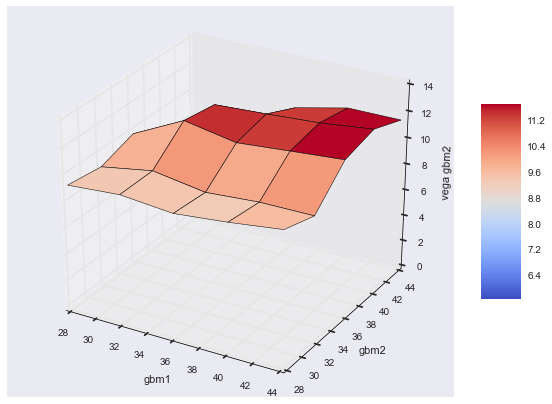

In [70]:
plot_greeks_3d([a_1, a_2, vega_2], ['gbm1', 'gbm2', 'vega gbm2'])

## More than Two Risk Factors

The principles of working with multi-risk valuation classes can be illustrated quite well in the two risk factor case. However, there is---in theory---**no limitation on the number of risk factors** used for derivatives modeling.

### Four Asset Basket Option

Consider a **maximum basket option** on four different risk factors. We add a **jump diffusion** as well as a **stochastic volatility** model to the mix

In [71]:
me3 = market_environment('me3', dt.datetime(2015, 1, 1))
me4 = market_environment('me4', dt.datetime(2015, 1, 1))

In [72]:
me3.add_environment(me1)
me4.add_environment(me1)

In [73]:
# for jump-diffusion
me3.add_constant('lambda', 0.5)
me3.add_constant('mu', -0.6)
me3.add_constant('delta', 0.1)
me3.add_constant('model', 'jd')

In [74]:
# for stoch volatility model
me4.add_constant('kappa', 2.0)
me4.add_constant('theta', 0.3)
me4.add_constant('vol_vol', 0.2)
me4.add_constant('rho', -0.75)
me4.add_constant('model', 'sv')

In [75]:
val_env.add_constant('paths', 10000)
val_env.add_constant('frequency', 'W')
val_env.add_curve('time_grid', None)

In this case, we need to specify **three correlation** values.

In [76]:
risk_factors = {'gbm1' : me1, 'gbm2' : me2, 'jd' : me3, 'sv' : me4}
correlations = [['gbm1', 'gbm2', 0.5], ['gbm2', 'jd', -0.5], ['gbm1', 'sv', 0.7]]

The **payoff function** in this case gets a bit more complex.

In [77]:
# European maximum call payoff
payoff_1 = "np.maximum(np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']),"
payoff_2 = " np.maximum(maturity_value['jd'], maturity_value['sv'])) - 40, 0)"
payoff = payoff_1 + payoff_2

In [78]:
payoff

"np.maximum(np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']), np.maximum(maturity_value['jd'], maturity_value['sv'])) - 40, 0)"

However, the instantiation of the valuation classe remains the same.

In [79]:
vc = valuation_mcs_european_multi(
            name='European maximum call',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff)

### Example Output and Calculations

The following just displays some example output and the results from certain calculations.

In [80]:
vc.risk_factors

{'gbm1': <dx.dx_frame.market_environment at 0x1091ac650>,
 'gbm2': <dx.dx_frame.market_environment at 0x1091ac690>,
 'jd': <dx.dx_frame.market_environment at 0x109f106d0>,
 'sv': <dx.dx_frame.market_environment at 0x10a61fd50>}

In [81]:
vc.underlying_objects

{'gbm1': <dx.dx_models.geometric_brownian_motion at 0x10a6e4a90>,
 'gbm2': <dx.dx_models.geometric_brownian_motion at 0x10a6e4350>,
 'jd': <dx.dx_models.jump_diffusion at 0x10a6e48d0>,
 'sv': <dx.dx_models.stochastic_volatility at 0x10b90b390>}

In [82]:
vc.present_value()

13.191

The **correlation and Cholesky matrices** now are of shape 4x4.

In [83]:
vc.correlation_matrix

,gbm1,gbm2,jd,sv
gbm1,1.0,0.5,0.0,0.7
gbm2,0.5,1.0,-0.5,0.0
jd,0.0,-0.5,1.0,0.0
sv,0.7,0.0,0.0,1.0


In [84]:
vc.val_env.get_list('cholesky_matrix')

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.8660254 ,  0.        ,  0.        ],
       [ 0.        , -0.57735027,  0.81649658,  0.        ],
       [ 0.7       , -0.40414519, -0.2857738 ,  0.51478151]])

**Delta and vega estimates** are generated in exactly the same fashion as in the two risk factor case.

In [85]:
vc.delta('jd', interval=0.1)

0.4481

In [86]:
vc.delta('sv')

0.3723

In [87]:
vc.vega('jd')

6.0256

In [88]:
vc.vega('sv')

1.1536

### Delta for Jump Diffusion and Stochastic Vol Process

Of course, we cannot visualize **Greek surfaces** dependent on initial values for all four risk factors but still for two. In what follows we generate the **delta surfaces** with respect to the jump diffusion- and stochastic volatility-based risk factors.

In [89]:
delta_1 = np.zeros_like(a_1)
delta_2 = np.zeros_like(a_1)

In [90]:
%%time
for i in range(np.shape(delta_1)[0]):
    for j in range(np.shape(delta_1)[1]):
        vc.update('jd', initial_value=a_1[i, j])
        vc.update('sv', initial_value=a_2[i, j])
        delta_1[i, j] = vc.delta('jd')
        delta_2[i, j] = vc.delta('sv')

CPU times: user 11.1 s, sys: 1.43 s, total: 12.6 s
Wall time: 12.3 s


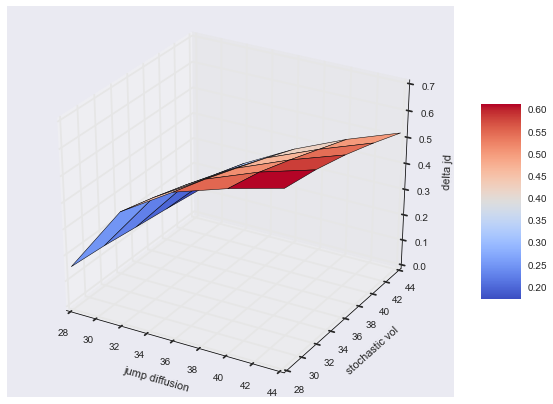

In [91]:
plot_greeks_3d([a_1, a_2, delta_1], ['jump diffusion', 'stochastic vol', 'delta jd'])

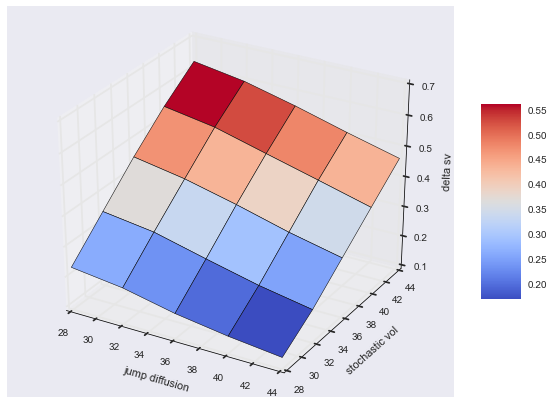

In [92]:
plot_greeks_3d([a_1, a_2, delta_2], ['jump diffusion', 'stochastic vol', 'delta sv'])

### Vega for Jump Diffusion and Stochastic Vol Process

Now the same exercise for the **vega surfaces** for the same two risk factors.

In [93]:
vega_1 = np.zeros_like(a_1)
vega_2 = np.zeros_like(a_1)

In [94]:
%%time
for i in range(np.shape(vega_1)[0]):
    for j in range(np.shape(vega_1)[1]):
        vc.update('jd', initial_value=a_1[i, j])
        vc.update('sv', initial_value=a_2[i, j])
        vega_1[i, j] = vc.vega('jd')
        vega_2[i, j] = vc.vega('sv')

CPU times: user 10.9 s, sys: 1.39 s, total: 12.3 s
Wall time: 11.9 s


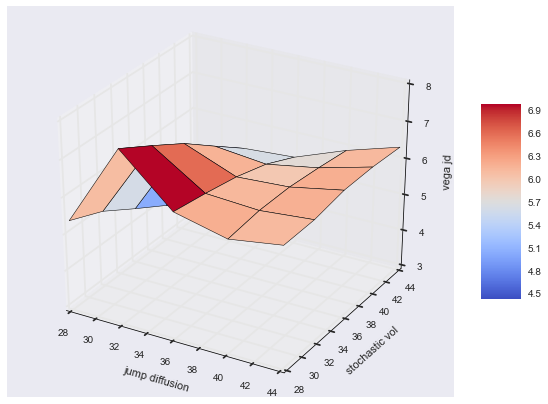

In [95]:
plot_greeks_3d([a_1, a_2, vega_1], ['jump diffusion', 'stochastic vol', 'vega jd'])

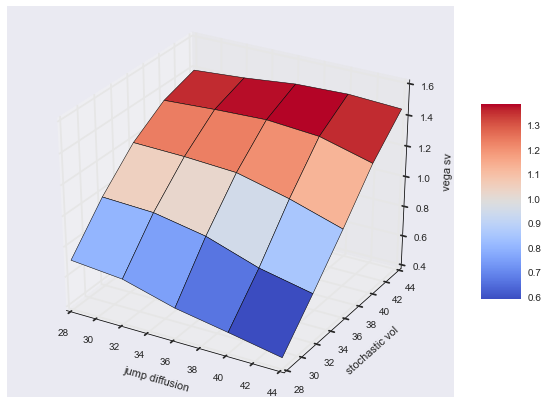

In [96]:
plot_greeks_3d([a_1, a_2, vega_2], ['jump diffusion', 'stochastic vol', 'vega sv'])

### American Exercise

As a final illustration consider the case of an **American minimum put option** on the four risk factors. This again is a step that leads to a much increased computational burden due to the necessity to apply the least-squares regression approach.

In [97]:
# payoff of American minimum put option
payoff_am_1 = "np.maximum(40 - np.minimum(np.minimum(instrument_values['gbm1'], instrument_values['gbm2']),"
payoff_am_2 = "np.minimum(instrument_values['jd'], instrument_values['sv'])), 0)"
payoff_am = payoff_am_1 + payoff_am_2

In [98]:
vca = valuation_mcs_american_multi(
            name='American minimum put',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_am)

However, another illustration that even such a complex instrument can be handled as elegantly as the most simple one (i.e. European option on single risk factor). Let us compare the **present value estimates** for both the European and American maximum basket options. 

In [99]:
# restore initial values
vc.update('jd', initial_value=36., volatility=0.1)
vc.update('sv', initial_value=36., volatility=0.1)
%time vc.present_value()

CPU times: user 4.91 ms, sys: 1 µs, total: 4.91 ms
Wall time: 4.92 ms


13.191

In [100]:
%time vca.present_value()

CPU times: user 1.49 s, sys: 385 ms, total: 1.88 s
Wall time: 1.69 s


14.305

In [101]:
%time vca.delta('gbm1')

CPU times: user 2.59 s, sys: 695 ms, total: 3.28 s
Wall time: 2.92 s


-0.0081

In [102]:
%time vca.delta('gbm2')

CPU times: user 2.61 s, sys: 694 ms, total: 3.3 s
Wall time: 2.93 s


-0.2241

In [103]:
%time vca.vega('jd')

CPU times: user 2.65 s, sys: 701 ms, total: 3.35 s
Wall time: 2.98 s


1.2914

In [104]:
%time vca.vega('sv')

CPU times: user 2.7 s, sys: 702 ms, total: 3.4 s
Wall time: 3.04 s


0.7437

In [105]:
print "Duration for whole notebook %.2f in min" % ((time.time() - t0) / 60)

Duration for whole notebook 3.45 in min


**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)